In [1]:
import sys
sys.path.append('../../src')

from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from imblearn.over_sampling import ADASYN, SMOTE

import visualization.visualize as vis
import models.evaluation as ev

In [2]:
filename = '../../data/raw/Myocardial infarction complications Database.csv'
data = pd.read_csv(filename)
data

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,...,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2.0,1.0,1.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,...,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0.0,0.0,0.0,2.0,NaN,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,1696,77.0,0,0.0,4.0,2.0,1.0,NaN,2.0,0.0,...,0,0,1,0,1,0,0,0,0,3
1696,1697,70.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1697,1698,55.0,1,3.0,6.0,2.0,2.0,NaN,0.0,0.0,...,0,0,0,0,0,0,0,1,0,6
1698,1699,79.0,0,2.0,2.0,2.0,1.0,NaN,2.0,0.0,...,0,0,0,1,0,0,0,0,0,1


# Data Preparation

In [3]:
ID_COLS = ['ID']
TARGET_COLS = ['FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
               'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN', 'LET_IS']
TARGET_COL = 'LET_IS'

In [4]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=42)

print('data_train:', data_train.shape)
print('data_test:', data_test.shape)

data_train: (1190, 124)
data_test: (510, 124)


In [5]:
data_train[TARGET_COL].value_counts(dropna=False)

0    1003
1      76
3      38
6      20
7      16
2      15
4      14
5       8
Name: LET_IS, dtype: int64

In [6]:
data_test[TARGET_COL].value_counts(dropna=False)

0    426
1     34
3     16
7     11
4      9
6      7
5      4
2      3
Name: LET_IS, dtype: int64

In [7]:
data_train[TARGET_COL][data_train[TARGET_COL] > 0] = 1
data_test[TARGET_COL][data_test[TARGET_COL] > 0] = 1

<ipython-input-7-520b1ebd3a4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[TARGET_COL][data_train[TARGET_COL]  > 0] = 1
c:\users\weldl\miniconda3\envs\work\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-7-520b1ebd3a4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test[TARGET_COL][data_test[TARGET_COL]  > 0] = 1
c:\

In [8]:
data_train[TARGET_COL].value_counts(dropna=False)

0    1003
1     187
Name: LET_IS, dtype: int64

In [9]:
data_test[TARGET_COL].value_counts(dropna=False)

0    426
1     84
Name: LET_IS, dtype: int64

In [10]:
def data_preparation(x_df, y_cols, target_col):
    x_array = x_df.drop(columns=y_cols)
    y_true = x_df[target_col].values
    return x_array, y_true

x_train, y_train = data_preparation(data_train, TARGET_COLS+ID_COLS, TARGET_COL)
x_test, y_test = data_preparation(data_test, TARGET_COLS+ID_COLS, TARGET_COL)

In [11]:
x_train

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1133,48.0,1,2.0,6.0,2.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
900,59.0,0,0.0,6.0,2.0,1.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
682,78.0,0,1.0,4.0,2.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
767,64.0,1,0.0,2.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
177,68.0,0,0.0,5.0,2.0,2.0,NaN,2.0,0.0,5.0,...,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,73.0,1,0.0,3.0,2.0,2.0,NaN,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1294,63.0,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
860,58.0,1,2.0,4.0,2.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1459,64.0,0,1.0,1.0,2.0,2.0,NaN,2.0,0.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [12]:
y_train

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [13]:
x_test

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1492,67.0,0,1.0,0.0,0.0,2.0,NaN,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
115,59.0,0,0.0,0.0,0.0,0.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
135,58.0,1,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
352,61.0,1,0.0,0.0,0.0,2.0,NaN,2.0,0.0,7.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1302,77.0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,62.0,1,0.0,4.0,2.0,1.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
471,43.0,1,1.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
322,69.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1235,80.0,0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [14]:
y_test

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

# Pre-processing

In [15]:
feature_cols = np.array(x_train.columns[~np.isin(x_train.columns, ID_COLS+TARGET_COLS)])
feature_cols

array(['AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST',
       'IBS_NASL', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A', 'nr_11',
       'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01',
       'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01',
       'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03',
       'zab_leg_04', 'zab_leg_06', 'S_AD_KBRIG', 'D_AD_KBRIG',
       'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST',
       'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im',
       'post_im', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02',
       'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08',
       'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04',
       'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09',
       'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04',
       'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08',
       'n_p

In [16]:
# Data cleaning:
features_cleaner = ColumnTransformer([
                        ("features cleaning", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1), feature_cols),
                        ])

In [17]:
# Pre-processing pipeline:
preprocessor = Pipeline([('data cleaning', features_cleaner),
                         ])

In [18]:
x_train_encoded = preprocessor.fit_transform(x_train)
x_train_encoded

array([[48.,  1.,  2., ...,  1.,  0.,  0.],
       [59.,  0.,  0., ...,  0.,  0.,  0.],
       [78.,  0.,  1., ...,  1.,  0.,  0.],
       ...,
       [58.,  1.,  2., ...,  0.,  1.,  0.],
       [64.,  0.,  1., ...,  0.,  0.,  1.],
       [78.,  0.,  2., ...,  1.,  0.,  0.]])

In [19]:
x_test_encoded = preprocessor.transform(x_test)
x_test_encoded

array([[67.,  0.,  1., ...,  0.,  0.,  0.],
       [59.,  0.,  0., ...,  1.,  0.,  0.],
       [58.,  1.,  0., ...,  1.,  0.,  0.],
       ...,
       [69.,  1.,  0., ...,  1.,  0.,  0.],
       [80.,  0.,  0., ...,  1.,  0.,  0.],
       [63.,  1.,  1., ...,  0.,  0.,  1.]])

# Plottting Embeddings:

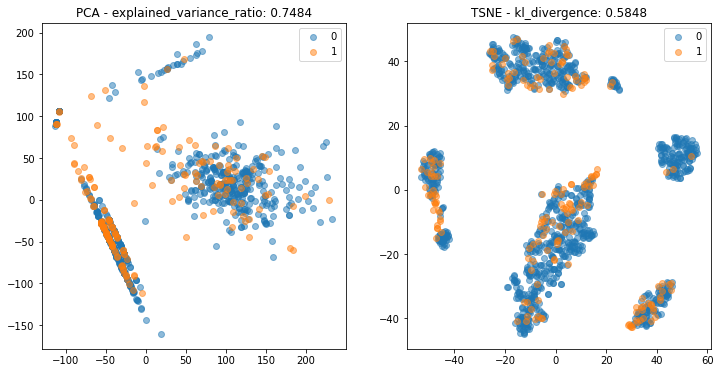

In [20]:
vis.plot_embeddings(x_train_encoded, y_train)

# Dealing with the imbalance

In [21]:
print('Original train dataset  classes distribution:', Counter(y_train))

sm = SMOTE(random_state=42, k_neighbors=5)
x_train_encoded, y_train = sm.fit_resample(x_train_encoded, y_train)
# ada = ADASYN(random_state=42, n_neighbors=5)
# x_train_encoded, y_train = ada.fit_resample(x_train_encoded, y_train)

print('Resampled train dataset classes distribution:', Counter(y_train))

Original train dataset  classes distribution: Counter({0: 1003, 1: 187})
Resampled train dataset classes distribution: Counter({0: 1003, 1: 1003})


In [22]:
print('Original test dataset classes distribution:', Counter(y_test))

Original test dataset classes distribution: Counter({0: 426, 1: 84})


# Plottting Embeddings (after re-balancing):

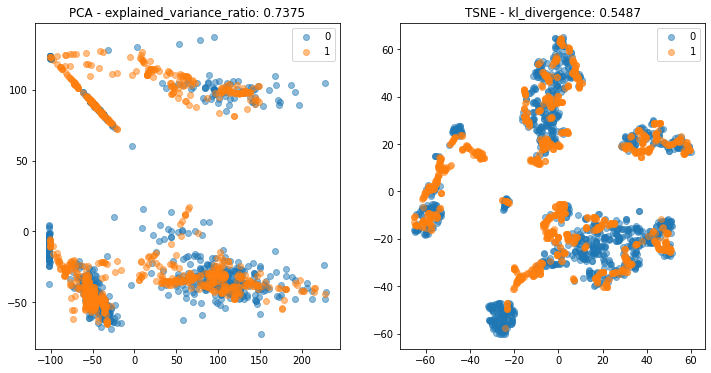

In [23]:
vis.plot_embeddings(x_train_encoded, y_train)

# Training a basic model

In [24]:
n_jobs = 4

In [25]:
# Random Forest:
param_grid = {'bootstrap': [False, True],
              'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [10, 50, 100, 200, 300, 500]}

rf_clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=50,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
rf_clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50, n_jobs=4,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [10, 50, 100, 200, 300,
                                                         500]},
                   scoring='balanced_accuracy', verbose=1)

In [26]:
# Logistic Regression:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty': ['l1', 'l2'],
              'max_iter': list(range(100,800,100)),
               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
             }

lr_clf = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid, n_iter=50,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
lr_clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\users\weldl\miniconda3\envs\work\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.81957463        nan 0.87489303 0.77170149 0.87786318        nan
        nan 0.8295199  0.80013433 0.81957463 0.87936816        nan
 0.75774378        nan 0.59073383 0.82504478 0.75524876        nan
 0.70491294 0.83999751        nan 0.81508706 0.81308209        nan
 0.8793607  0.87389801 0.8519602  0.87687065 0.87489303        nan
 0.82504478        nan        nan 0.76270398 0.85546269 0.81158955
 0.83450249 0.82006965        nan 0.87786318 0.67749254        nan
        nan 0.75524876 0.82254975        nan 0.69943035        nan
 0.8255398         nan]
  warnings.warn(


RandomizedSearchCV(estimator=LogisticRegression(), n_iter=50, n_jobs=4,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     600, 700],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   scoring='balanced_accuracy', verbose=1)

In [28]:
# KNN:
param_grid={'n_neighbors': np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'metric': ['minkowski', 'euclidean', 'manhattan'],
           }

knn_clf = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_grid, n_iter=50,
                            scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
knn_clf.fit(x_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_iter=50, n_jobs=4,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'weights': ['uniform', 'distance']},
                   scoring='balanced_accuracy', verbose=1)

In [29]:
# # SVM:
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#               'degree': [1, 2, 3, 4, 5],
#              }

# svm_clf = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=50,
#                              scoring='balanced_accuracy', n_jobs=n_jobs, verbose=1)
# svm_clf.fit(x_train_encoded, y_train)

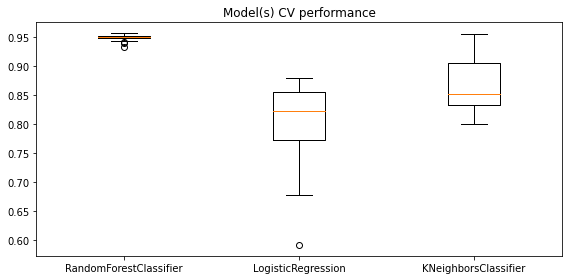

In [30]:
estimators_list = [rf_clf, lr_clf, knn_clf]
ev.plot_estimators_cvperf(estimators_list)

In [31]:
model = estimators_list[np.argmax([pd.DataFrame(m.cv_results_)['mean_test_score'].dropna().max() for m in estimators_list])].best_estimator_
model.fit(x_train_encoded, y_train)

RandomForestClassifier(bootstrap=False, max_depth=90, max_features=3,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300)

# Evaluating the model:

Classes evaluated: ['0', '1']
Correctly classified......: 461/510
Accuracy (simple) ........: 0.90
Balanced acc.  ...........: 0.72
Balanced acc. (adjusted)..: 0.45
Acc. norm (Recall avgs) ..: 0.72
Precision = tp / (tp + fp): [0.9  0.93] -> accuracy of positive predictions
Recall    = tp / (tp + fn): [0.99 0.45] -> sensibility (true positive rate)
F1 score .................: [0.95 0.61] -> harmonic mean


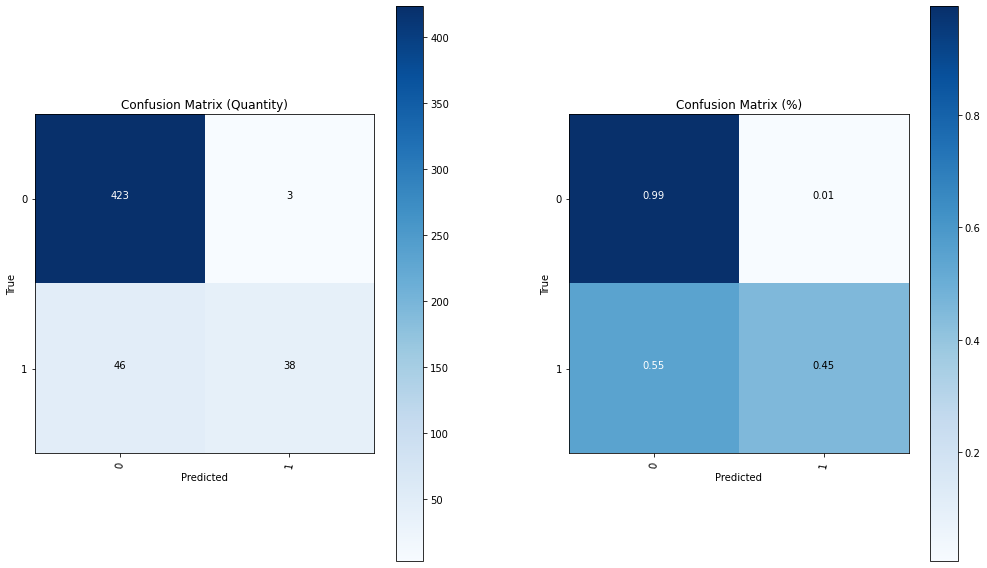

In [32]:
y_pred = model.predict(x_test_encoded)
test_metrics = ev.performance_measures(y_test, y_pred)

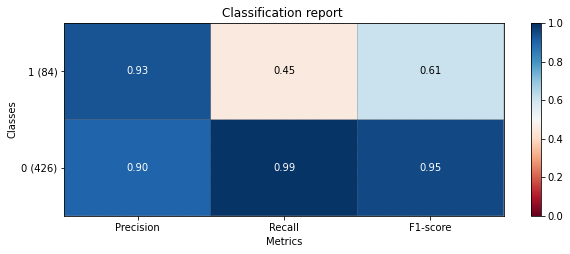

In [33]:
ev.plot_classification_report(y_test, y_pred)